# From skylight input to behavioural output: a computational model of the insect polarised light compass

### Evripidid Gkanias, Benjamin Risse, Michael Mangan, and Barbara Webb

#### School of Informatics, the University of Edinburgh, Edinburgh, United Kingdom


### Abstract
Many insects navigate by integrating the distances and directions travelled on an outward path, allowing direct return to the starting point. Fundamental to the reliability of this process is the use of a neural compass based on external celestial cues. Here we examine how such compass information could be reliably computed by the insect brain, given realistic constraints on the sky polarisation pattern and the insect eye sensor array. By processing the degree of polarisation in different directions for different parts of the sky, our model can directly estimate the solar azimuth and also infer the confidence of the estimate. We introduce a method to correct for tilting of the sensor array, as might be caused by travel over uneven terrain. We also show that the confidence can be used to approximate the change in sun position over time, allowing the compass to remain fixed with respect to 'true north' during long excursions. We demonstrate that the compass is robust to disturbances and can be effectively used as input to an existing neural model of insect path integration. We discuss the plausibility of our model to be mapped to known neural circuits, and to be implemented for robot navigation.

In [1]:
from plots import *
from results import *
from compoundeye import POLCompassDRA
from compoundeye.evaluation import evaluate
from compoundeye.geometry import fibonacci_sphere
from environment import Sun, Sky, get_seville_observer

from datetime import datetime
from scipy.io import loadmat
from astropy.stats import circmean, circvar, rayleightest
import numpy as np
import matplotlib.pyplot as plt

sun = Sun()
seville_obs = get_seville_observer()

# Skylight modalities

Information available from the different modalities of the light in the sky for different positions in the sky-dome. (A) The luminance pattern of the sky is proportional to its intensity and describes the amount of light per area unit existing in a specific direction. Along with the cromaticity coordinates, it can provide spectral information. (B) The degree of linear polarisation pattern in the sky based on the scattering of the light on atmospheric particles. It is defined by the fraction of the polarised portion over the total intensity. (C) The angle of polarisation pattern in the sky is defined by the average e-vector (electric part of an electromagnetic wave) orientation of the photons.

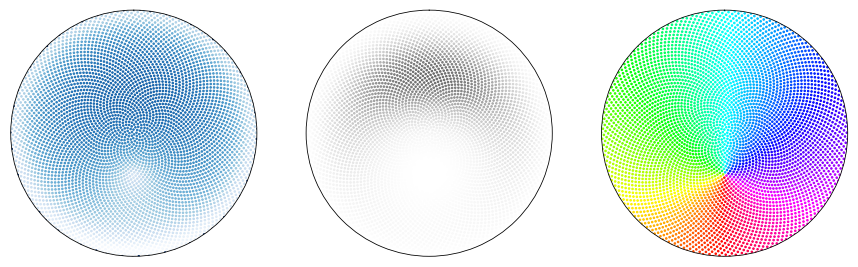

In [6]:
%matplotlib inline

samples = 5000

theta, phi = fibonacci_sphere(samples, 180)
sky = Sky(np.pi/6, np.pi)
y, p, a = sky(theta, phi)

plt.figure("sky", figsize=(15, 5))
plot_sky(phi, theta, y, p, a).show()

# POL-neurons response

(Left) Simulated response of the two photo-receptors in one unit in partially linearly polarised light of intensity Y = 7.5  and degree of polarisation d = 0.9 against different e-vector orientations. (Right) Simulated response of the POL-neuron to the input of the neurons in the left figure; the dashed line shows the response of the POL-OP interneuron, and the solid line is the response of the POL-neuron (normalised difference).

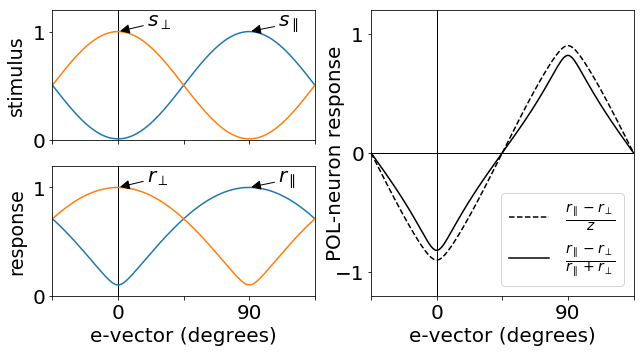

In [3]:
Y = 7.5  # light intensity
pol = .9  # degree of polarasation
e = np.linspace(-np.pi / 4, 3 * np.pi / 4, 361)  # e-vector orientation
act_func = np.sqrt  # activation function

s_1 = Y * (np.square(np.cos(e)) + np.square(np.sin(e)) * np.square(1. - pol))
s_2 = Y * (np.square(np.sin(e)) + np.square(np.cos(e)) * np.square(1. - pol))

r_1 = act_func(s_1)
r_2 = act_func(s_2)

z = act_func(Y)
r_z = (r_2 - r_1) / z
r_pol = (r_2 - r_1) / (r_2 + r_1)

plt.figure("photoreceptors", figsize=(9, 5))
plot_pol_neurons_rotating_linear_polariser(
    [np.rad2deg(e), s_1 / Y], [np.rad2deg(e), s_2 / Y],
    [np.rad2deg(e), r_1 / z], [np.rad2deg(e), r_2 / z],
    [np.rad2deg(e), r_z], [np.rad2deg(e), r_pol]).show()

# The tilting function that compensates for tilt

The differing weightings of ommatidia input under three levels of tilt: from left to right $\delta = 0^\circ$, $\delta = 30^\circ$ and $\delta = 60^\circ$. Darker shading indicates higher weighting.

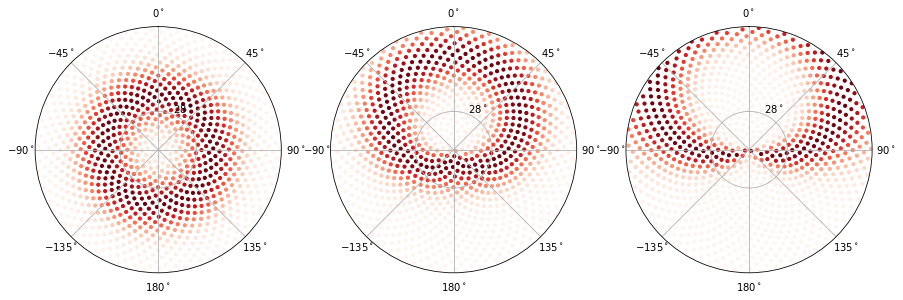

In [8]:
plt.figure("gate-ring", figsize=(15, 5))
plot_gate_ring(theta_t=np.deg2rad(0), subplot=131)
plot_gate_ring(theta_t=np.deg2rad(30), subplot=132)
plot_gate_ring(theta_t=np.deg2rad(60), subplot=133).show()

# Using confidence of the estimate to compensate for time

The confidence value of the compass response varies with the solar elevation (black dots). Within the range $18^\circ - 67^\circ$ this relationship can be used to estimate the elevation using the equation below:

$\theta_s' = 26^\circ \cdot \Big[1 - 2\frac{\sin^{-1}(1 - \tau_s)}{180^\circ}\Big] + 15^\circ$

with domain $\{\tau_s \in \mathbb{R} | 0 \le \tau_s \le 2\}$ and range $\{\theta_s' \in \mathbb{R}|18^\circ < \theta_s' < 67^\circ\}$. The top left plot is without disturbance, while the rest are with disturbance $\eta = 6\%$, $\eta = 26\%$ and $\eta = 43\%$.

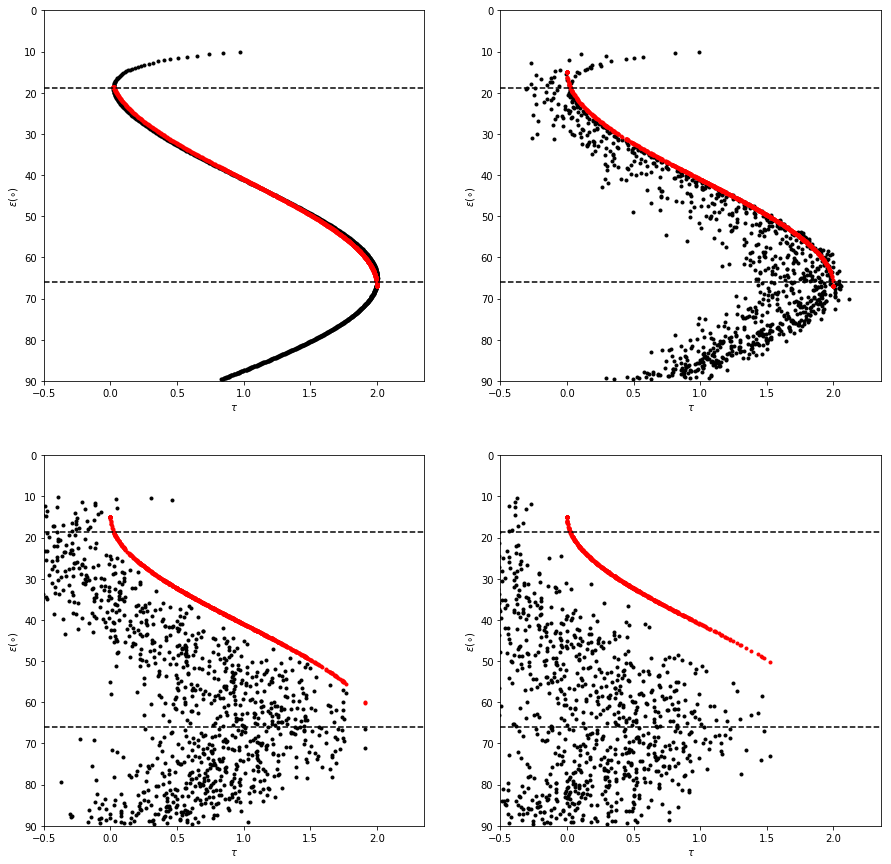

In [4]:
plt.figure("res2ele", figsize=(15, 15))
plot_res2ele(noise=0.00, subplot=221)
plot_res2ele(noise=0.06, subplot=222)
plot_res2ele(noise=0.26, subplot=223)
plot_res2ele(noise=0.43, subplot=224).show()

The relationship between the solar elevation, azimuth and change rate of azimuth. This relationaship is given by the heuristic equation below (black line in plots):

$\frac{d\phi_s}{dt} = \Big[\exp\Big(\frac{\theta_s - 36^\circ}{10^\circ}\Big) + 9^\circ\Big] \circ/h$

Error: 3.2521 +/- 0.1002 | N = 869


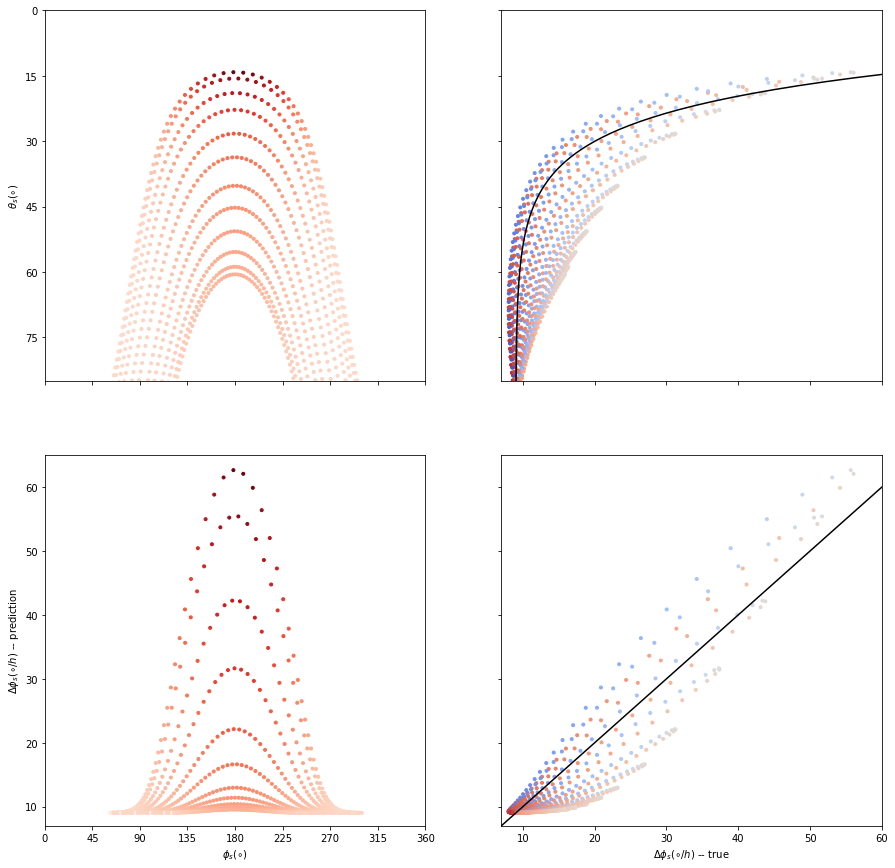

In [3]:
seville_obs.date = datetime.strptime("2018-06-21", "%Y-%m-%d")

plt.figure("ephemeris", figsize=(15, 15))
plot_ephemeris(seville_obs).show()

# Step-by-step processing of the compass model

(A) The sum-of sinusoids mechanism detects the solar azimuth; this is encoded in both the SOL- and TCL-layers and the activation of the two layers look identical, as the zenith (green) point is alighned with the sensor orientation. (B) The tilt compensation mechanism corrects the predicted solar azimuth using tilting information; the sensor has been tilted $30^\circ$ NNW (so now the zenith point is $30^\circ$ SSE). (C) The time compensation mechanism corrects for the solar azimuth changes using the solar elevation; 8 hours have passed so the sun has moved $120^\circ$ clockwise but the compass is still aligned to the same direction.

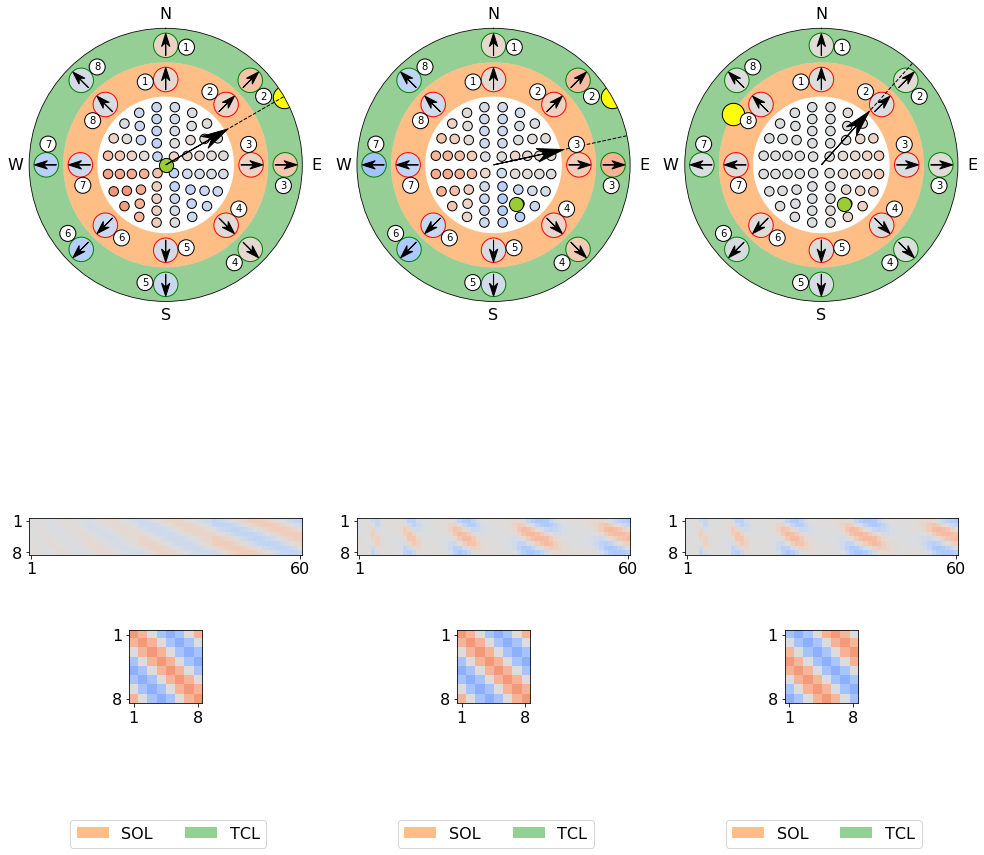

In [10]:
plt.figure("Step-by-step processing of the compass model", figsize=(15, 15))
params = evaluate(sun_azi=np.pi/3, sun_ele=np.pi/3, snap=True, tilting=False)
kwargs = {'subplot': 131}
plot_snapshot(*params, **kwargs)
params = evaluate(sun_azi=np.pi/3, sun_ele=np.pi/3, snap=True, tilting=(np.pi/9, 5*np.pi/6))
kwargs = {'subplot': 132}
plot_snapshot(*params, **kwargs)
params = evaluate(sun_azi=-np.pi/3, sun_ele=np.pi/4, snap=True, tilting=(np.pi/9, 5*np.pi/6), ephemeris=True)
kwargs = {'subplot': 133}
plot_snapshot(*params, **kwargs).show()

# The accuracy of the compass

(A, B) Mean absolute angular error (coloured solid lines), MAE $\pm$ SE, and confidence (black dashed line), $\tau_s$, against the solar elevation for different disturbance levels, when the sensor points towards the zenith. (C) The mean absolute angular error (black solid line) and confidence (black dashed line) against different disturbance levels.

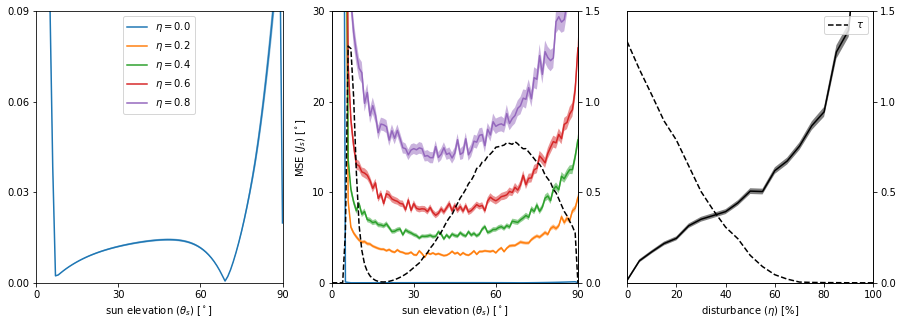

In [3]:
plt.figure("Accuracy", figsize=(15, 5))
plot_accuracy().show()

# Optimisation of gating parameters

Average angular error for different gating parameters. The lowest cost (green dot; $J = 10.47^\circ \pm 0.12^\circ$, N = 8,500) is for ring radius $\theta_g = 40^\circ$ and width (variance) $\sigma_g = 13^\circ$.

Minimum cost (10.47) for Sigma = 13.00, Shift = 39.00


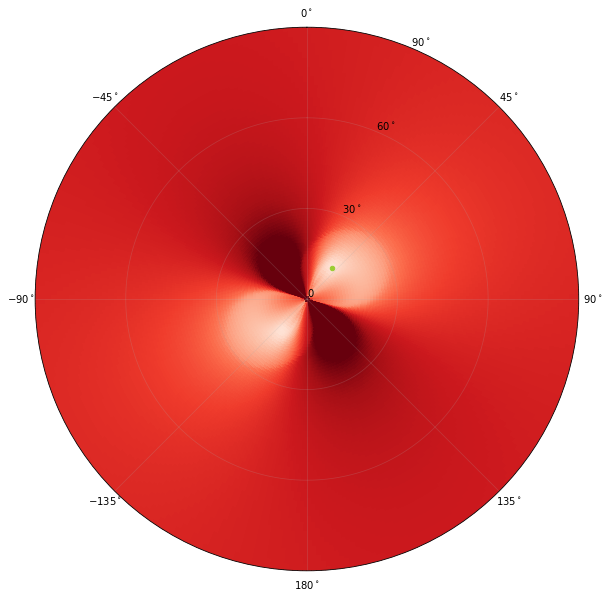

In [16]:
plt.figure("Gating parameters optimisation", figsize=(10, 10))
plot_gate_optimisation().show()

# Dealing with tilt 

Visualisation of the azimuthal angular error with respect to the sun position, i.e. $\epsilon \in [0, 90]$ and $\alpha \in [0, 360)$, for three tilting angles of the snsor: from left to right $\delta = 0^\circ$,  $\delta = 30^\circ$ and  $\delta = 60^\circ$; with (bottom) and without (top) using the gating function.

Tilt             overall              0 deg              30 deg             60 deg     
---------------------------------------------------------------------------------------
Mean cost    65.78 +/- 0.6289    0.63 +/- 0.0142    35.68 +/- 0.0083    104.01 +/- 0.0140


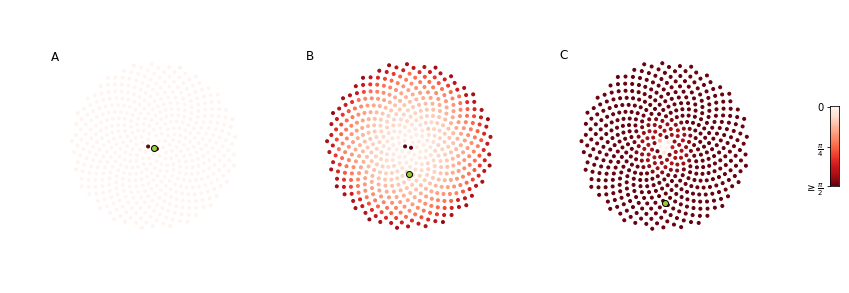

Tilt             overall              0 deg              30 deg             60 deg     
---------------------------------------------------------------------------------------
Mean cost    10.71 +/- 0.1622    0.47 +/- 0.0142    9.53 +/- 0.0040    13.16 +/- 0.0035


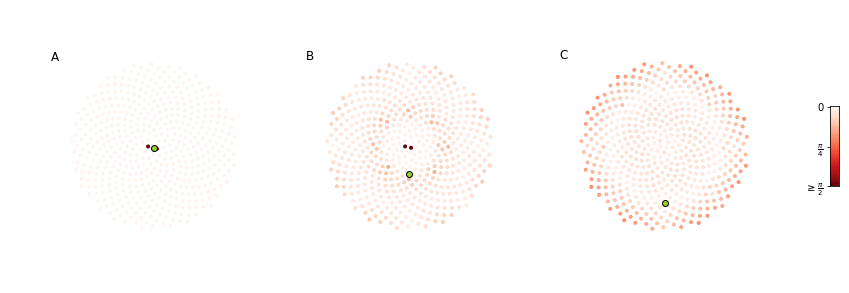

In [4]:
plt.figure("Not dealing with tilt", figsize=(15, 5))
plot_gate_cost(sigma=100.).show()
plt.figure("Dealing with tilt", figsize=(15, 5))
plot_gate_cost().show()

# Optimal compass structural parameteres

The performance of the compass for different topological parameters. (A) The error as a function of the number of units, $n$; the receptive field is fixed at $\omega = 56^\circ$. (B) The error as a fuction of the receptive field, $\omega$; the resolution (ration between $\omega$ and $n$) is fixed so that number of units is $n=60$ for $\omega = 56^\circ$. (C) Values of the objective function on the $\omega \times n$ plane; red shades illustrate the degree of error; the green line shows the receptive fild value associated with the minimum error for different number of units.

Minimum cost (9.55) for N = 336, Omega = 56.00
Mean omega 55.99 +/- 0.3367


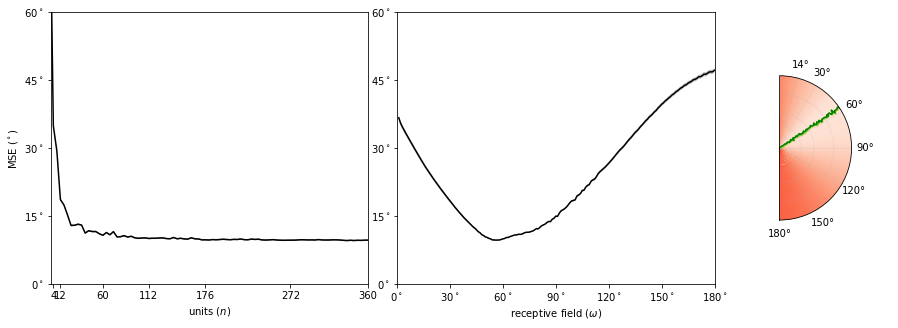

In [5]:
plt.figure("Structure optimisation", figsize=(15, 5))
plot_structure_optimisation().show()

# Visualisation of the disturbance

Examples of the responses of the POL units in (A) a non-disturbed sky condition, (B) with $\eta = 33\%$ disturbance; (C) with $\eta = 66\%$ disturbance; and (D) with $\eta = 99\%$ disturbance.

2018/6/21 09:00:00


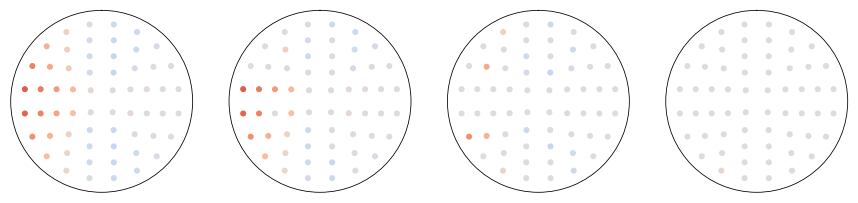

In [22]:
seville_obs.date = datetime.strptime("2018-06-21 9:00", "%Y-%m-%d %H:%M")
sun.compute(seville_obs)

sky = Sky(theta_s=np.pi / 2 - sun.alt, phi_s=sun.az)
dra = POLCompassDRA()

plt.figure("sky", figsize=(15, 3.5))
r_pol = dra(sky, noise=0.0)
plot_disturbance(dra.phi, dra.theta, r_pol, subplot=141)
r_pol = dra(sky, noise=0.33)
plot_disturbance(dra.phi, dra.theta, r_pol, subplot=142)
r_pol = dra(sky, noise=0.66)
plot_disturbance(dra.phi, dra.theta, r_pol, subplot=143)
r_pol = dra(sky, noise=0.99)
plot_disturbance(dra.phi, dra.theta, r_pol, subplot=144).show()

# Path integration in uneven terrain

To demonstrate the performance of the sensor in a more realistic scenario, we intregrated the compass and path integration models, testing how the compass accurately affects the foraging  and homing paths. Here is the uneven terrain map we use to test the tilt compensation mechanism of our model in practice. We set up the experiments to take place at 10am in Seville, Spain ($37^\circ$23'33.03"N, $5^\circ$53'01.95"W). The maximum altitude variance is 1m and the maximum tilting angle noticed in all the experiments is $\delta = 52^\circ$.

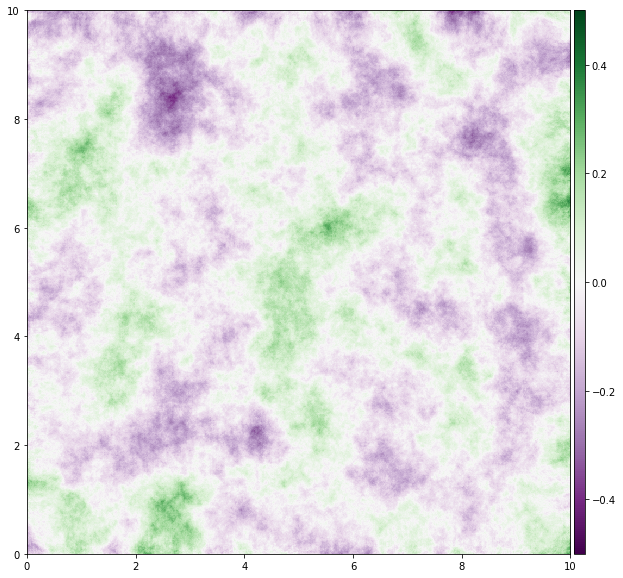

In [4]:
max_altitude = .5  # maximum altitude [m]
tau = .6  # the smoothing parameter in order to create hills and valeys

# create terrain
x_terrain = np.linspace(0, 10, 1001, endpoint=True)
y_terrain = np.linspace(0, 10, 1001, endpoint=True)
x_terrain, y_terrain = np.meshgrid(x_terrain, y_terrain)
z_terrain = get_terrain(max_altitude, tau, x_terrain, y_terrain)

plt.figure("Uneven terrain", figsize=(10, 10))
plot_terrain(z_terrain, max_altitude).show()

In [ ]:
create_paths()  # create the paths for different terrain and sky conditions

# Behavioural simulation for the path integration trask

Outward (away from the nest -- bold lines) and inward paths (towards the nest -- faded lines) of artificial ants that use the proposed compass to orient themselves in different disturbance and inclination levels. Each panel of the top row shows the route of the ant in different maximum surface steepness ($\delta \in \{15^\circ, 28^\circ, 38^\circ, 47^\circ, 52^\circ\}$; different coloured lines in the same panel) which is associated with the respective altitude variance in the terrain shown above ($\alpha \in \{0.2\,\text{m}, 0.4\,\text{m}, 0.6\,\text{m}, 0.8\,\text{m}, 1.0\,\text{m}\}$. The panels of the bottom row show the routes of the ant in different sky-disturbance levels ($\eta \in \{0.0, 0.2, 0.4, 0.6, 0.8\}$; different coloured lines in the same panel) for a specific maximum inclination.

Later, there is the comparison of the path integration performance in terms of tortuosity generated by the above experiment.

/home/odin/projects/venv/local/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


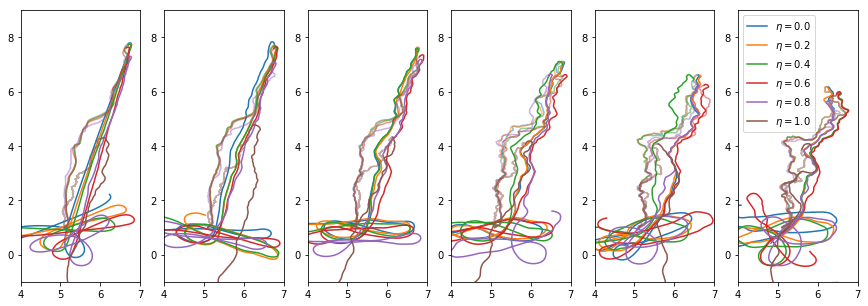

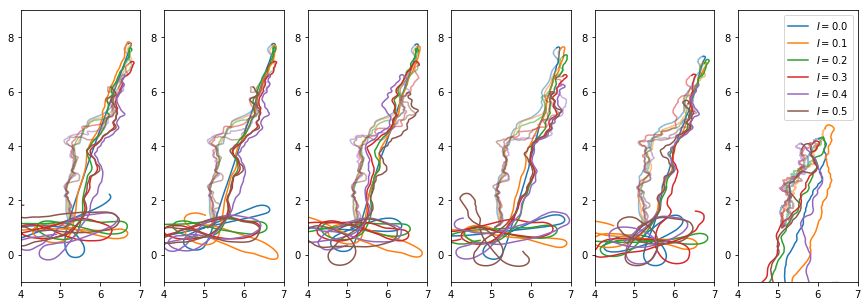

In [3]:
stats = np.load("data/pi-stats.npz")

ipaths = stats["ipath"]
opaths = stats["opath"]
d_xs = stats["d_x"]
d_cs = stats["d_c"]
max_alts = stats["max_alt"]
noises = stats["noise"]
un_max_alts = np.sort(np.unique(max_alts))
un_noises = np.sort(np.unique(noises))

plt.figure("Inclinations", figsize=(15, 5))
for j, max_alt in enumerate(un_max_alts):
    for id, noise in enumerate(un_noises):
        ipath = ipaths[np.all([max_alt == max_alts, noise == noises], axis=0)][0]
        opath = opaths[np.all([max_alt == max_alts, noise == noises], axis=0)][0]
        plot_route(opath, ipath, id=id, label=r'$\eta = %.1f$' % noise, subplot=101 + len(un_max_alts) * 10 + j)
plt.legend()

plt.figure("Disturbances", figsize=(15, 5))
for j, noise in enumerate(un_noises):
    for id, max_alt in enumerate(un_max_alts):
        ipath = ipaths[np.all([max_alt == max_alts, noise == noises], axis=0)][0]
        opath = opaths[np.all([max_alt == max_alts, noise == noises], axis=0)][0]
        plot_route(opath, ipath, id=id, label=r'$I = %.1f$' % max_alt, subplot=101 + len(un_max_alts) * 10 + j)
plt.legend()
plt.show()

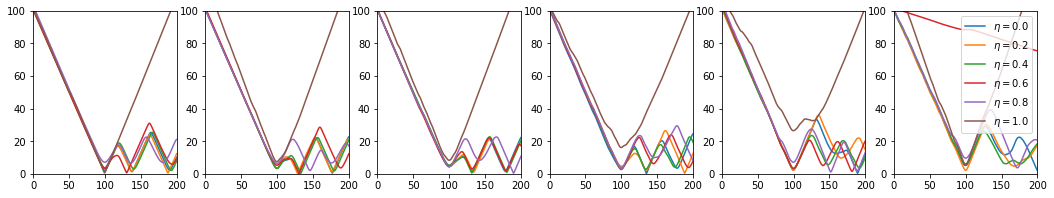

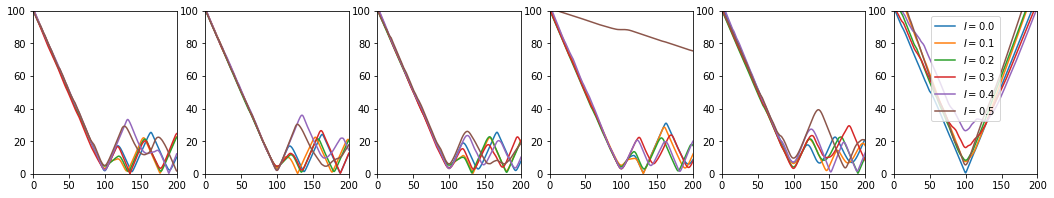

In [5]:
plt.figure("Inclinations' tortuosity", figsize=(18, 3))
for j, max_alt in enumerate(un_max_alts):
    for id, noise in enumerate(un_noises):
        d_x = d_xs[np.all([max_alt == max_alts, noise == noises], axis=0)]
        d_c = d_cs[np.all([max_alt == max_alts, noise == noises], axis=0)]
        plot_tortuosity(d_c, d_x, id=id, label=r'$\eta = %.1f$' % noise, subplot=101 + len(un_max_alts) * 10 + j)
plt.legend()

plt.figure("Disturbances' tortuosity", figsize=(18, 3))
for j, noise in enumerate(un_noises):
    for id, max_alt in enumerate(un_max_alts):
        d_x = d_xs[np.all([max_alt == max_alts, noise == noises], axis=0)]
        d_c = d_cs[np.all([max_alt == max_alts, noise == noises], axis=0)]
        plot_tortuosity(d_c, d_x, id=id, label=r'$I = %.1f$' % max_alt, subplot=101 + len(un_noises) * 10 + j)
plt.legend()
plt.show()

In [ ]:
create_ephem_paths()  # create the paths for testing the ephemeris function

# Behavioural simulation for the path integration task in long runs

We scale up our experimental arena (by a factor of 120) to enable longer runs that demonstrate the performance of the time compensation mechanism. (Left) Path integration with (blue line) and without using the time compensation mechanism (orange line); direction of the sun at the beginning (10:00 am, $103.65^\circ$ clockwise from north) and end of the route (11:16 am, $127.47^\circ$ clockwise from north). (Right) Comparison of the path integration performance in terms of tortuosity generated by the above experiment.

/home/odin/projects/venv/local/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


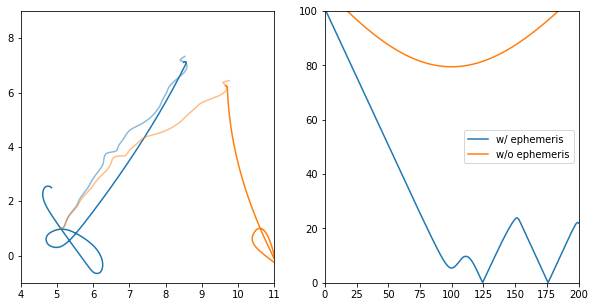

In [4]:
stats_ephem = np.load("data/pi-stats-ephem.npz")
stats_noephem = np.load("data/pi-stats-no-ephem.npz")

ipaths = np.vstack([stats_ephem["ipath"][:1], stats_noephem["ipath"][:1]])
opaths = np.vstack([stats_ephem["opath"][1][np.newaxis], stats_noephem["opath"][1][np.newaxis]])
d_xs = np.vstack([stats_ephem["d_x"][np.newaxis], stats_noephem["d_x"][np.newaxis]])
d_cs = np.vstack([stats_ephem["d_c"][np.newaxis], stats_noephem["d_c"][np.newaxis]])

plt.figure("Ephemeris", figsize=(10, 5))
plot_route(opaths[0], ipaths[0], id=0, label='ephemeris', subplot=121, xlim=[4, 11])
plot_route(opaths[1], ipaths[1], id=1, label='ephemeris', subplot=121, xlim=[4, 11])

plot_tortuosity(d_cs[0], d_xs[0], id=0, label="w/ ephemeris", subplot=122)
plot_tortuosity(d_cs[1], d_xs[1], id=1, label="w/o ephemeris", subplot=122)
plt.legend()

plt.show()

# Response of compass neurons in the locust brain

E-vector orientation resulting in maximum excitation, ${\phi}_{\max}$, of the real (desert locust) neurons in the CX.

## Rotating Linear Polariser: Real Tb1-neurons response

Each panel shows the response (black bars) and $\phi_\text{max}$ (red line) of a specific TB1-neuron in the CX. The different rows of the panel-grid show the location of the neurons in the PB. The columns show the response of different TB1-neurons in the desert locust brain supplied by Stanley Heinze and organised in rows with respect to their location; row 3 and 7 are empty due to a lack of data; different panels in the same row show different neurons in the same region.

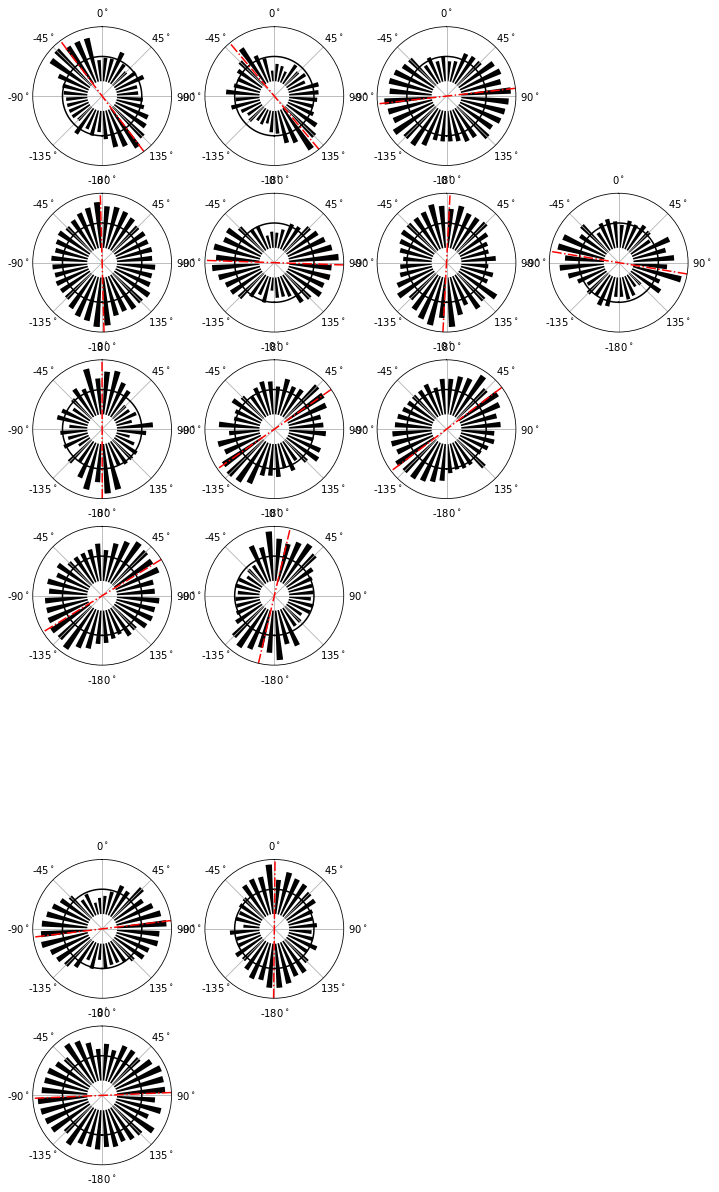

In [5]:
columns = [
    ['fz1028'],  # L8/R1
    ['060126', '060131', '050105a', 'fz1049'],  # L7/R2
    ['050329', '050309a', '050124b', '041215', 'fz1020', 'fz1038'],  # L6/R3
    ['060124', '060206a', '060206b', 'fz1016'],  # L5/R4
    ['050520', '040604b', 'fz1040'],  # L4/R5
    [],  # L3/R6
    ['050309b', '050222'],  # L2/R7
    ['041209', 'fz1051'],  # L1/R8
]

phi_tb1 = 3*np.pi/2 - np.linspace(0, np.pi, 8)
phi = np.linspace(np.deg2rad(5), np.deg2rad(355), 36)
tb1_phi_max = []
tb1_phi_mean = []
tb1_p_values = []
bl = .5

plt.figure("TB1 rotating linear polariser", figsize=(18, 24))

for j, filenames in enumerate(columns):
    col = j
    tb1_phi_mean.append([])
    tb1_p_values.append([])

    for i, filename in enumerate(filenames):
        if 'fz' in filename:
            continue
        tb1s = loadmat("data/TB1_neurons/mean_rotation_%s.mat" % filename)['mean_rotation'][:, ::2]
        tb1s = tb1s.reshape((-1, 2)).mean(axis=1).reshape((1, -1))

        z = tb1s.max() - tb1s.min()
        r_std = tb1s.std(axis=0) / np.sqrt(z)
        bl = .5
        r_mean = tb1s.flatten() / tb1s.max() - bl
        p_value = rayleightest(phi, weights=r_mean + bl)
        phi_mean_00 = circmean((phi - np.pi / 2) % np.pi + np.pi/2, weights=np.power(r_mean + bl, 8))
        phi_var_00 = circvar((phi - np.pi / 2) % np.pi + np.pi/2, weights=np.power(r_mean + bl, 8))
        phi_mean_90 = circmean(phi % np.pi, weights=np.power(r_mean + bl, 8))
        phi_var_90 = circvar(phi % np.pi, weights=np.power(r_mean + bl, 8))
        phi_mean = phi_mean_00 if phi_var_00 < phi_var_90 else phi_mean_90
        d_00 = np.absolute((phi_mean - phi_tb1[-1 - i] + np.pi) % (2 * np.pi) - np.pi)
        d_pi = np.absolute((phi_mean - phi_tb1[-1 - i]) % (2 * np.pi) - np.pi)
        if d_00 > d_pi:
            phi_mean += np.pi
        tb1_phi_mean[j].append(phi_mean)
        tb1_p_values[j].append(p_value)

        plot_circ_response(phi, r_mean, r_std, phi_mean, subplot=(8, 6, j * 6 + i + 1))

for i, phi_mean_i in enumerate(tb1_phi_mean):
    col = i
    for j, phi_mean_j in enumerate(phi_mean_i):
        d_00 = np.absolute((phi_mean_j - phi_tb1[-1 - i] + np.pi) % (2 * np.pi) - np.pi)
        d_pi = np.absolute((phi_mean_j - phi_tb1[-1 - i]) % (2 * np.pi) - np.pi)
        if d_00 > d_pi:
            phi_mean_i[j] += np.pi

    phi_max_i = circmean(np.array(phi_mean_i)) % (2 * np.pi)
    tb1_phi_max.append(phi_max_i)
plt.show()

## Rotating Linear Polariser: Simulated TCL-neurons response

The response of the artificial TCL-neurons in a similar stimuli to the one used in the desert locust experiment.

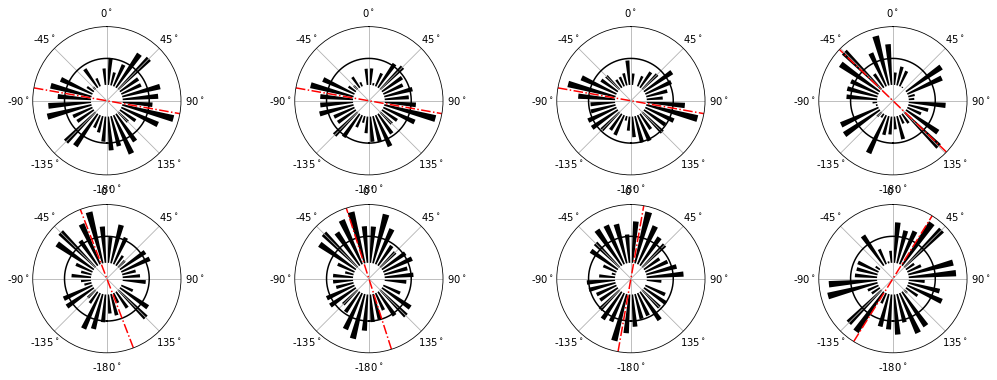

In [7]:
phi_tb1 = 3 * np.pi / 2 - np.linspace(np.pi, 0, 8)


def responses(sun_ele=np.pi / 3, uniform=True, noise=.5, bl=.5):
    sun_azi = np.linspace(-np.pi, np.pi, 36, endpoint=False)
    sun_ele = np.full_like(sun_azi, sun_ele)
    
    phi_maxs = []
    r_means = []
    r_stds = []
    p_values = []
    tb1s = np.empty((0, sun_azi.shape[0], 8), dtype=sun_azi.dtype)
    
    for n_tb1 in xrange(8):
        tb1s = np.empty((0, sun_azi.shape[0], 8), dtype=sun_azi.dtype)
    
        for _ in np.linspace(0, 1, 100):
            d_deg, d_eff, t, phi, r_tb1 = evaluate(uniform_polariser=uniform,
                                                   sun_azi=sun_azi, sun_ele=sun_ele, tilting=False, noise=noise)
            tb1s = np.vstack([tb1s, np.transpose(r_tb1, axes=(1, 0, 2))])
    
        r_mean = np.median(tb1s[..., n_tb1], axis=0)
        z = r_mean.max() - r_mean.min()
    
        r_mean = (r_mean - r_mean.min()) / z - bl
        r_means.append(r_mean)
        r_stds.append(tb1s[..., n_tb1].std(axis=0) / np.sqrt(z))
    
        p_values.append(rayleightest(sun_azi, weights=r_mean + bl))
        phi_max = circmean(sun_azi, weights=np.power(r_mean + bl, 50))
        phi_maxs.append(phi_max)
    
    z = tb1s.max() - tb1s.min()
    tb1s = (tb1s - tb1s.min()) / z
    phis = np.transpose(np.array([[sun_azi] * 100] * 8), axes=(1, 2, 0))
    phi_means = circmean(phis, axis=1, weights=np.power(tb1s, 50)).T
    
    return np.array(phi_maxs)[::-1], phi_means[::-1], np.array(r_means)[::-1], np.array(r_stds)[::-1], np.array(p_values)[::-1]


tcl_phi_max, tcl_phi_mean, tcl_r_mean, tcl_r_std, tcl_p_values = responses(uniform=True, noise=0.)

plt.figure("TCL rotating linear polariser", figsize=(18, 6))
for n_tcl, r_mean, r_std, phi_max in zip(range(len(tcl_phi_max)), tcl_r_mean, tcl_r_std, tcl_phi_max):
    plot_circ_response(phi, r_mean, 0. * r_std, phi_max, subplot=(2, 4, n_tcl + 1))
plt.show()

tcl_phi_max, tcl_phi_mean, tcl_r_mean, tcl_r_std, tcl_p_values = responses(uniform=True, noise=0.1)

## Rotating Sky: Simulated TCL-neurons response

The response of the same TCL-neurons when the artificial DRA is exposed to natural sky-light extracted by a simulated rotating sky.

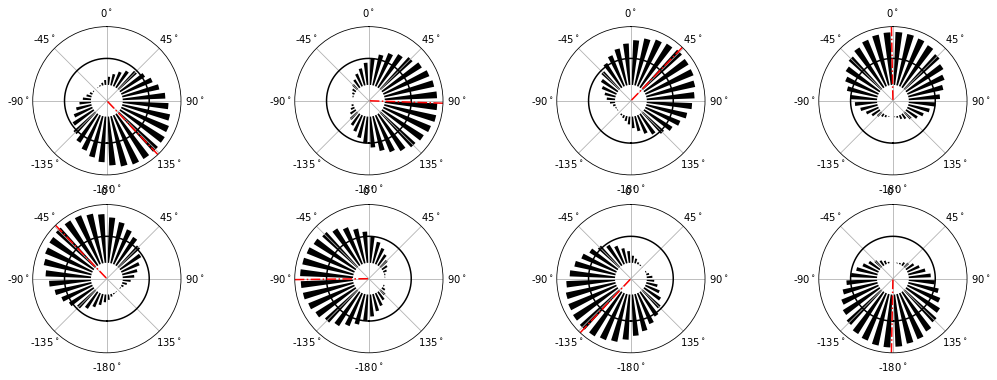

In [9]:
tcl_sky_phi_max, tcl_sky_phi_mean, tcl_sky_r_mean, tcl_sky_r_std, tcl_sky_p_values = responses(
    uniform=False, noise=0.1)

plt.figure("TCL rotating sky", figsize=(18, 6))
for n_tcl, r_mean, r_std, phi_max in zip(
        range(len(tcl_sky_phi_max)), tcl_sky_r_mean, tcl_sky_r_std, tcl_sky_phi_max):
    plot_circ_response(phi, r_mean, 0. * r_std, phi_max, uniform=False, subplot=(2, 4, n_tcl + 1))
plt.show()

## Summary of the neural-responses results

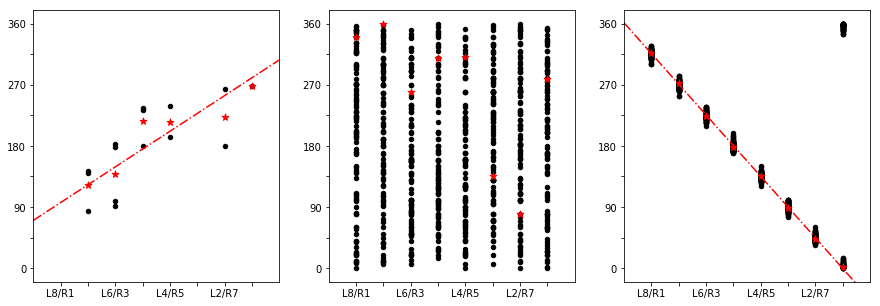

In [13]:
plt.figure("TB1/TCL summary", figsize=(15, 5))

plot_summary_response(tb1_phi_mean, tb1_phi_max, fit_line=True, subplot=131)
plot_summary_response(tcl_phi_mean, tcl_phi_max, fit_line=False, subplot=132)
plot_summary_response(tcl_sky_phi_mean, tcl_sky_phi_max, fit_line=True, subplot=133)
plt.show()

Copyright &copy; 2019, Insect Robotics Group, Institude of Perception, Action and Behaviour, School of Informatics, the University of Edinburgh